# Point Processes

Here, we'll start looking at how do you estimate things: particularly the "intensity" of a point process and the K-function. For the point process intensity, we'll mosty use `numpy` functions. For the `K-function` we'll use a combination of `geopandas` spatial joins and `numpy` functions. We'll also see how to find the nearest neighbor along the way, using `sklearn.neighbors.NearestNeighbors`.

First, let's simulate a point process. Simulation is a very powerful tool for checking that your estimation procedure works as expected because you know what its result should be. We'll start by simulating a homogenous Poisson point process. Let's simulate 100 points with uniform random locations on `[0,10]x[0,10]`.

In [1]:
import numpy as np

points = np.random.rand(2,100) # We're choosing 100 locations with 2 coordinate values each
points = points*10 # np.random.rand chooses values on [0,1] so multiply by 10 to put them on [0,10]
points

array([[8.23860685, 8.09878472, 1.79812897, 3.71715116, 9.08154023,
        3.31617151, 6.4617686 , 9.91035987, 6.16145259, 5.15461445,
        8.15523486, 3.22518087, 4.63941592, 4.51017904, 4.74239501,
        5.5705386 , 1.7888181 , 2.2795026 , 3.03274743, 2.70128816,
        6.38092271, 0.60494504, 9.66067413, 8.98843318, 7.30330627,
        9.02228706, 2.14827012, 2.25709448, 7.51298179, 8.66355551,
        5.32123215, 6.83398281, 8.91602947, 9.45093742, 6.81830129,
        9.76098874, 0.89104528, 8.24147035, 9.57690932, 1.0914309 ,
        8.1684691 , 5.83320993, 2.77661418, 9.12795841, 2.09241107,
        0.35723667, 4.68767098, 8.96632703, 7.9804899 , 3.8471838 ,
        3.89612437, 5.35888955, 5.39866996, 3.1937707 , 1.15806   ,
        9.90820669, 6.97499138, 2.53136134, 6.72342502, 5.21208066,
        7.31398519, 6.51514854, 6.16401197, 4.86318436, 8.9496218 ,
        2.71945474, 5.80574822, 1.38224662, 4.37642621, 6.6899716 ,
        5.11962093, 8.00744827, 9.64980517, 2.29

Now let's put them in a `GeoDataFrame` and plot their locations.

<Axes: >

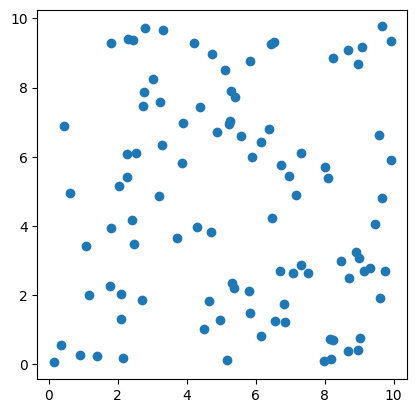

In [2]:
import pandas as pd
import geopandas as gpd
import shapely.geometry as shg

gdf = pd.DataFrame({
    'x':points[0,:], # First set of 100
    'y':points[1,:] # second set
})
gdf['point'] = gdf.apply(lambda x: shg.Point(x['x'],x['y']),axis=1) # make the points
gdf = gpd.GeoDataFrame(gdf,geometry='point',crs='EPSG:4326') # turn the DataFrame into a GeoDataFrame (CRS doesn't matter here)
gdf.plot()

Looks pretty random! The way we've set this up, the average 1 x 1 square should have 1 point in it. Let's see if that's the case.

In [13]:
bls = np.arange(0,10,1) # bottom left corner positions
b_df = pd.DataFrame({'b':bls}) # A data frame of the bottom coordinates
l_df = pd.DataFrame({'l':bls}) # A data frame of the left coordinates
bl_df = pd.merge(b_df,l_df,how='cross') # cross merge to get each bottom-left combination
bl_df

,b,l
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
95,9,5
96,9,6
97,9,7
98,9,8


<Axes: >

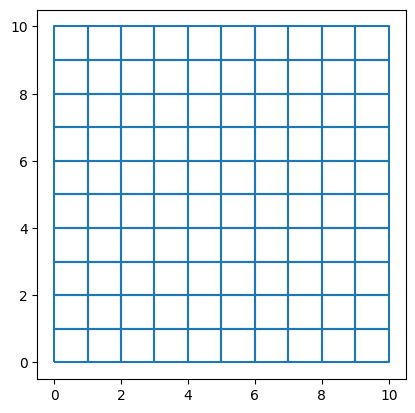

In [14]:
bl_df['cell'] = bl_df.apply(lambda x: shg.box(x['l'],x['b'],
                                             x['l']+1,x['b']+1), # xmax, ymax = left + 1, bottom +1
                           axis=1)
bl_df = gpd.GeoDataFrame(bl_df,geometry='cell',crs="EPSG:4326")
bl_df.boundary.plot()

<Axes: >

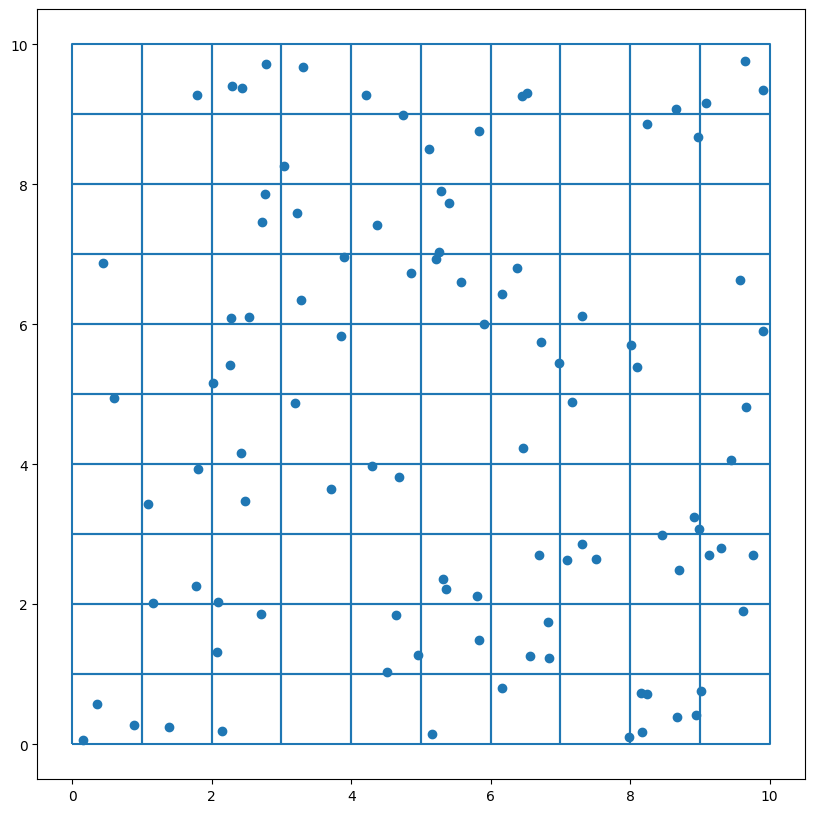

In [15]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(10,10))

bl_df.boundary.plot(ax=ax)
gdf.plot(ax=ax)

Obviously, some cells have more than 1 point and some have none at all. But we're interested in how many points they have _on average_.

In [16]:
gdf['points'] = 1 # Keep track of how many points there are
bl_df_points = gpd.sjoin(bl_df,gdf,how='left') # Want to keep the cells with no points in them!
bl_df_points

,b,l,cell,index_right,x,y,points
0,0,0,"POLYGON ((1 0, 1 1, 0 1, 0 0, 1 0))",75.0,0.154795,0.057283,1.0
0,0,0,"POLYGON ((1 0, 1 1, 0 1, 0 0, 1 0))",36.0,0.891045,0.269108,1.0
0,0,0,"POLYGON ((1 0, 1 1, 0 1, 0 0, 1 0))",45.0,0.357237,0.575144,1.0
1,0,1,"POLYGON ((2 0, 2 1, 1 1, 1 0, 2 0))",67.0,1.382247,0.241652,1.0
2,0,2,"POLYGON ((3 0, 3 1, 2 1, 2 0, 3 0))",26.0,2.148270,0.187289,1.0
...,...,...,...,...,...,...,...
97,9,7,"POLYGON ((8 9, 8 10, 7 10, 7 9, 8 9))",NaN,NaN,NaN,NaN
98,9,8,"POLYGON ((9 9, 9 10, 8 10, 8 9, 9 9))",29.0,8.663556,9.073030,1.0
99,9,9,"POLYGON ((10 9, 10 10, 9 10, 9 9, 10 9))",4.0,9.081540,9.156617,1.0
99,9,9,"POLYGON ((10 9, 10 10, 9 10, 9 9, 10 9))",7.0,9.910360,9.343901,1.0


In [17]:
bl_df_points['points'] = bl_df_points['points'].fillna(0) # Cells that didn't match have NaN for points, so make those 0
cell_counts = bl_df_points.groupby(['b','l'])['points'].sum().reset_index() # Within each cell, count the number of points
cell_counts['points'].mean()

np.float64(1.0)

This should be very close to 1! We can also see that this process is homogenous by repeating this process many times and seeing that each cell averages out to 1 point.

In [22]:
def simrun_homog(): # No argument
    '''
    This function just does all the stuff we've done above 
    '''
    points = np.random.rand(2,100)
    points = points*10 

    gdf = pd.DataFrame({
    'x':points[0,:], 
    'y':points[1,:] 
    })
    gdf['point'] = gdf.apply(lambda x: shg.Point(x['x'],x['y']),axis=1) 
    gdf = gpd.GeoDataFrame(gdf,geometry='point',crs='EPSG:4326') 

    gdf['points'] = 1 
    bl_df_points = gpd.sjoin(bl_df,gdf,how='left') 

    bl_df_points['points'] = bl_df_points['points'].fillna(0) 
    cell_counts = bl_df_points.groupby(['b','l'])['points'].sum().reset_index() 

    return(cell_counts)


many_runs = pd.concat([simrun_homog() for i in range(0,1000)]) # Run the simulation 1000 times and append all the results
many_runs

,b,l,points
0,0,0,0.0
1,0,1,2.0
2,0,2,2.0
3,0,3,0.0
4,0,4,1.0
...,...,...,...
95,9,5,1.0
96,9,6,0.0
97,9,7,0.0
98,9,8,0.0


<Axes: >

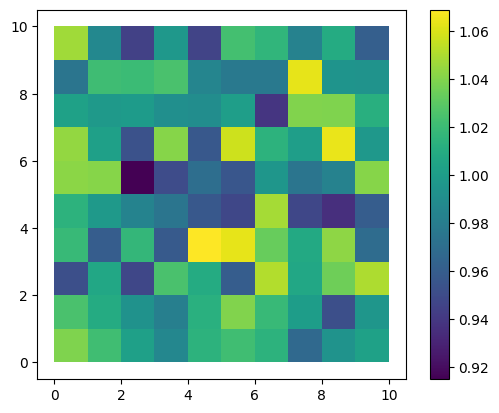

In [23]:
many_runs_avg = many_runs.groupby(['b','l'])['points'].mean().reset_index() #average number of points across 1000 runs
many_runs_avg = pd.merge(bl_df,many_runs_avg,on=['b','l']) # Merge back on boundaries
many_runs_avg = gpd.GeoDataFrame(many_runs_avg, geometry='cell',crs="EPSG:4326")
many_runs_avg.plot(column='points',legend=True)

All are very close to 1, so we can see that this is indeed a homogenous point process!

Now let's try estimating the intensity. The first method we discussed was to use histograms. Here, we'll try different bin sizes to show how it affects our estimates. As we've already shown in our simulations, ideally we would get an intensity of 1 everywhere.

Our histogram estimation procedure will be very similar to what we've done above. There are two main differences: first, we'll vary the size of the cells. Second, we'll normalize by the area of the cells.

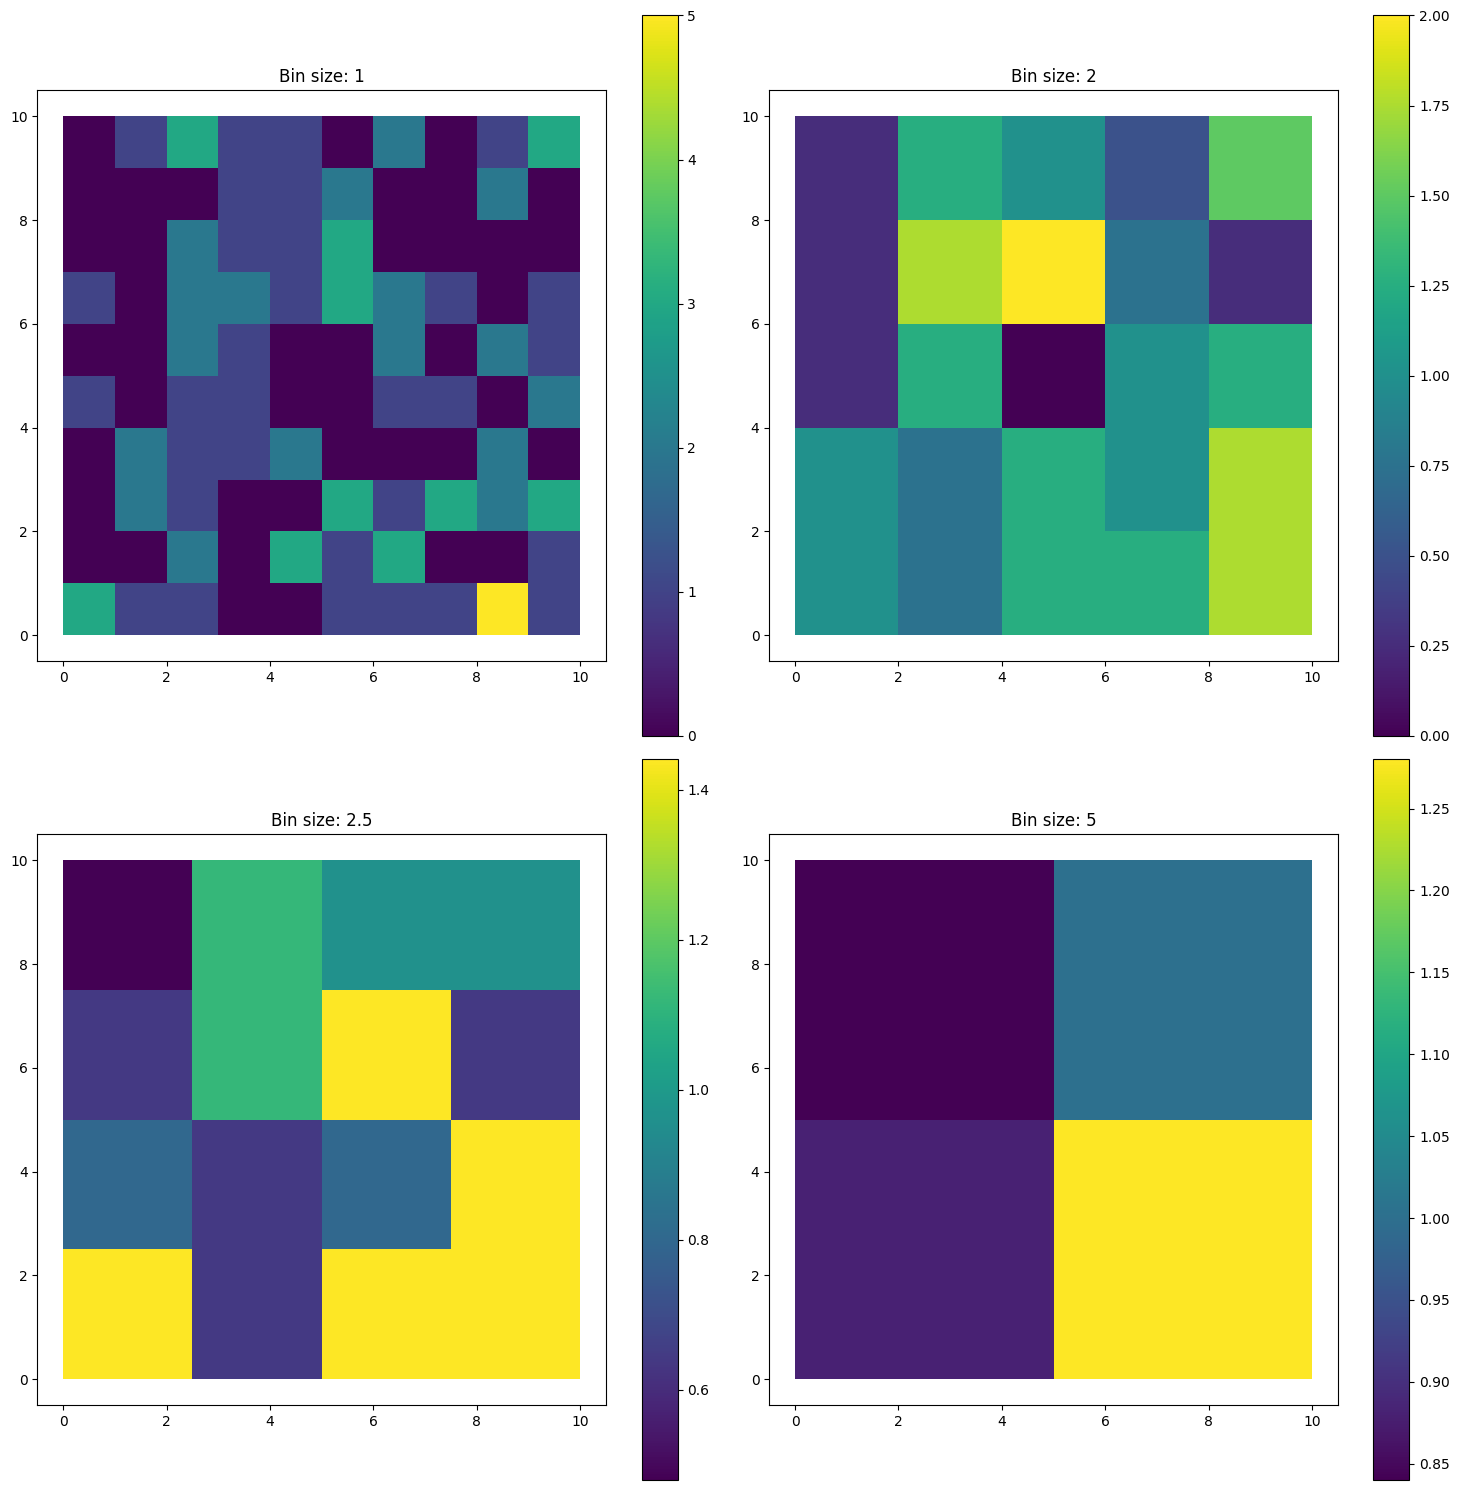

In [29]:
def histogram(bin_size): # Make a function that takes bin size as an argument
    bls = np.arange(0,10,bin_size) # go from 0 to 10 in steps of bin_size
    b_df = pd.DataFrame({'b':bls})
    l_df = pd.DataFrame({'l':bls})
    bl_df = pd.merge(b_df,l_df,how='cross') 

    
    bl_df['cell'] = bl_df.apply(lambda x: shg.box(x['l'],x['b'],
                                             x['l']+bin_size,x['b']+bin_size), # xmax, ymax = left + bin_size, bottom + bin_size
                           axis=1)
    bl_df = gpd.GeoDataFrame(bl_df,geometry='cell',crs="EPSG:4326")
    
    bl_df_points = gpd.sjoin(bl_df,gdf,how='left') 
    bl_df_points['points'] = bl_df_points['points'].fillna(0) 
    cell_counts = bl_df_points.groupby(['b','l'])['points'].sum().reset_index() 

    histogram_values = pd.merge(bl_df,cell_counts,on=['b','l']) # Merge back on boundaries
    histogram_values = gpd.GeoDataFrame(histogram_values, geometry='cell',crs="EPSG:4326")
    histogram_values['est_intensity'] = histogram_values['points']/(bin_size**2) # divide by square of bin size to normalize
    return(histogram_values)

fig,axs = plt.subplots(2,2, figsize=(15,15))

bin_sizes = [1, 2, 2.5, 5] # bin sizes we'll test
for i in range(0,4):
    histogram_df = histogram(bin_sizes[i])

    histogram_df.plot(ax = axs[i//2,i%2],column='est_intensity',legend=True)
    axs[i//2,i%2].set_title(f'Bin size: {bin_sizes[i]}')

plt.tight_layout()

You can see that with smaller bin sizes we get much more variable estimates, whereas with larger bin sizes they're much closer to 1. The tradeoff here is that if the process _were_ inhomogenous, larger bins would smooth over some of that spatial variation in intensity.

We'll skip kernel estimation for now and get onto nearest neighbor analysis. As mentioned in the intro, finding nearest neighbors is really easy with `sklearn.neighbors.NearestNeighbors` (documentation [here](https://scikit-learn.org/stable/modules/neighbors.html#neighbors)). Let's try finding the distance to each point's nearest neighbor and plotting the distribution of distances.

In [33]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2) # Need to use 2 because the closest neighbor will be the point itself!
nbrs.fit(gdf[['x','y']].to_numpy())
distances,indices = nbrs.kneighbors(gdf[['x','y']].to_numpy())
distances

array([[0.        , 0.08433526],
       [0.        , 0.33089104],
       [0.        , 0.66503645],
       [0.        , 0.67636909],
       [0.        , 0.42626063],
       [0.        , 0.54174019],
       [0.        , 0.9674561 ],
       [0.        , 0.49393784],
       [0.        , 0.60592621],
       [0.        , 1.10308707],
       [0.        , 0.08433526],
       [0.        , 0.52196452],
       [0.        , 0.64904192],
       [0.        , 0.50328694],
       [0.        , 0.60185027],
       [0.        , 0.49350988],
       [0.        , 0.52450987],
       [0.        , 0.25226367],
       [0.        , 0.47427099],
       [0.        , 0.63178715],
       [0.        , 0.43164692],
       [0.        , 1.43426348],
       [0.        , 0.78851329],
       [0.        , 0.18325831],
       [0.        , 0.68729975],
       [0.        , 0.34587253],
       [0.        , 0.76795009],
       [0.        , 0.34104924],
       [0.        , 0.30278711],
       [0.        , 0.42626063],
       [0.

The first column is all 0s because as I said, the closest point is the point of interest itself. The second column has the true distance to the points nearest neighbor. Let's add that to the data frame and plot its density using the `hist` method of pandas series.

<Axes: >

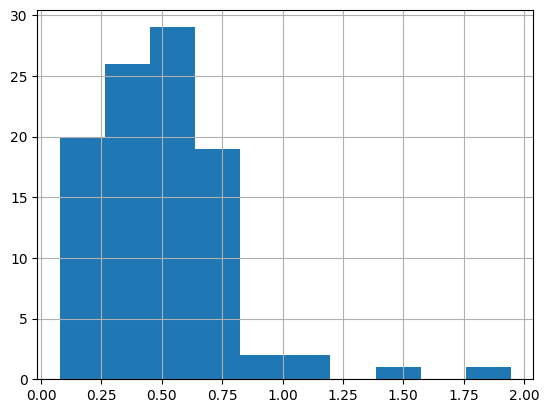

In [37]:
gdf['distance'] = distances[:,1]

gdf['distance'].hist()

So most have a neighbor somewhere between 0.05 and 0.75 away, while there are some outliers that are 1 or more away from a neighbor.

Now let's estimate the K-function. Recall that the definition of the K-function is the expected number of events within h distance of another event (normalized by the intensity of the process). Here, we'll focus on estimating the un-normalized version. So we need to iterate over many distances and check how many points are within that distance for the average point. We'll do this by making a function that buffers each point by a distance given as the argument, then performs a spatial join and averages the number of intersections.

In [43]:
def k_est(h): # takes distance h as argument
    buff = gdf[['x','y','point']].copy() # make a copy of gdf to buffer
    # we need a copy because we're going to spatial join gdf back on
    # don't want 'points' column
    buff['buff'] = buff['point'].apply(lambda x: x.buffer(h)) # buffer point by h
    buff = buff.set_geometry('buff') # change geometry from point to buff

    buff = gpd.sjoin(buff,gdf[['points','point']],
                    how='left') # again, want to keep buffers with no matches
    buff['points'] = buff['points'].fillna(0)
    buff = buff.groupby(['x','y'])['points'].sum().reset_index()
    return({'h':h,'k':buff['points'].mean()})

k_func_df = pd.DataFrame([k_est(h) for h in np.arange(0,10,0.1)])
k_func_df

,h,k
0,0.0,0.00
1,0.1,1.04
2,0.2,1.14
3,0.3,1.24
4,0.4,1.40
...,...,...
95,9.5,95.68
96,9.6,96.18
97,9.7,96.68
98,9.8,96.94


<Axes: xlabel='h'>

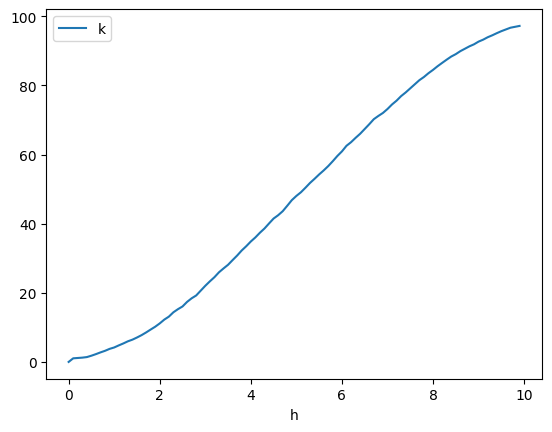

In [45]:
k_func_df.plot(x='h',y='k')